A notebook analyzing all the ITL sensors in the etraveler. A scoring algorithm is developed and applied at the bottom.

This should be considered as a {\bf pre-filter} only, as it does not take into account other important characteristics, including bad segments, glow, and other problems. The ranking is therefore just the starting point for sensor selection.

It appears there is a possible problem with how the noise is being pulled out of etraveler, so we'll keep it out of the metric for now and just check the top performers by hand. The plots for each sensor are shown below.

Thanks to Richard Dubois and Emily Phillips Longley for the starting-point tools. Richard has since set up an improved set of tools for accessing eT (see 17 July presentation in the Camera Test meeting), but this script uses the older tool set. Eventually, we want to merge with DM.

- S. Ritz updated 17 July 2018

In [1]:
# this is the partner code that can run anywhere using the pickled data, produced by script at SLAC
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages
import datetime
import collections
import numpy as np
import argparse
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import scipy as sc
import scipy.signal
import textwrap
import pylab as pl

# this magic command makes plots appear within the notebook
%matplotlib inline

# avoid an annoying warning
plt.rcParams.update({'figure.max_open_warning': 0})


# define figure size parameters to make figures larger than default
figwidth=30
figheight=10


In [2]:
import pickle
# I ran rank_ITLnew.py at SLAC, then pickled the data. 
f=open('ITLnewdump.p','rb')
expDict=pickle.load(f)
ccd_list=pickle.load(f)
bias_dic=pickle.load(f, encoding='latin1')
RTM_dic=pickle.load(f)
f.close()
len(ccd_list), len(bias_dic)

(137, 137)

In [3]:
def get_CTI(d, ccd):

        cti_low_serial = []
        cti_high_serial = []
        cti_low_parallel = []
        cti_high_parallel = []

        for amp in d['cte'][ccd]['steps']['cte_offline']['cte'][1:]:
            cti_low_serial.append(amp['cti_low_serial'])
            cti_high_serial.append(amp['cti_high_serial'])
            cti_low_parallel.append(amp['cti_low_parallel'])
            cti_high_parallel.append(amp['cti_high_parallel'])

        ctils=np.array(cti_low_serial)
        ctihs=np.array(cti_high_serial)
        ctilp=np.array(cti_low_parallel)
        ctihp=np.array(cti_high_parallel)

        
        print(ccd,'\n sum serial low: %8.2e'% ctils.sum(), 
               '\n sum serial high: %8.2e'% ctihs.sum(), 
               '\n worst serial low: %8.2e'% max(cti_low_serial), 
               '\n worst serial high: %8.2e'% max(cti_high_serial),
               '\n worst parallel low: %8.2e'% max(cti_low_parallel), 
               '\n worst parallel high:%8.2e'% max(cti_high_parallel), '\n', '\n')
        

        return np.array(cti_low_serial), np.array(cti_high_serial), np.array(cti_low_parallel), np.array(cti_high_parallel)

In [4]:
def get_readnoise(d, ccd):

        read_noise = []

        for amp in d['readnoise'][ccd]['steps']['read_noise_offline']['read_noise'][1:]:
            read_noise.append(amp['read_noise'])

        return np.array(read_noise)

In [5]:
def get_nonlinearity(d, ccd):

        nonlinearity = []

        for amp in d['nonlinearity'][ccd]['steps']['flat_pairs_offline']['flat_pairs'][1:]:
            nonlinearity.append(amp['max_frac_dev'])

        return np.array(nonlinearity)

In [6]:
def defectsFraction(d, ccd, col_len=2000, totPixels=1024000.0):
        #sum defect types and express as fraction (per segment)
        # totPixels = 1025024 E2V, 1024000 ITL

        amps = []
        numBrightPixels = []
        numBrightColumns = []
        numDarkPixels = []
        numDarkColumns = []
        numTraps = []

        for amp in d['brightdefects'][ccd]['steps']['bright_defects_offline']['bright_defects']:
            numBrightPixels.append(amp['bright_pixels'])
            numBrightColumns.append(amp['bright_columns'])

        for amp in d['darkdefects'][ccd]['steps']['dark_defects_offline']['dark_defects']:
            numDarkPixels.append(amp['dark_pixels'])
            numDarkColumns.append(amp['dark_columns'])

        for amp in d['traps'][ccd]['steps']['traps_offline']['traps']:
            numTraps.append(amp['num_traps'])

        numBrightPixels = np.array(numBrightPixels[1:])
        numBrightColumns = np.array(numBrightColumns[1:])
        numDarkPixels = np.array(numDarkPixels[1:])
        numDarkColumns = np.array(numDarkColumns[1:])
        numTraps = np.array(numTraps[1:])

        return ((numBrightPixels+numDarkPixels+numTraps+col_len*(numBrightColumns + numDarkColumns))/totPixels), numBrightColumns

In [7]:
def metric(ccd_list, expDict, bias_dic, RTM_dic):
        ccd_dic={}
        for ccd in ccd_list:
            defectsfrac, nbcs = defectsFraction(expDict,ccd)
            nbc=nbcs.sum()

            ctils, ctihs, ctilp, ctihp = get_CTI(expDict,ccd)
            ctemax=max(ctils.max(),ctihs.max())
            rn = get_readnoise(expDict,ccd)

            bias = bias_dic[ccd]
            RTM = RTM_dic[ccd]
            nonlinearity = get_nonlinearity(expDict, ccd)

            # Score = sCTI/2 + defects/0.2% + nonlinearity/1% + Bias/5000
            Score = ctemax/2.e-6 + defectsfrac.mean()/0.002 + max(nonlinearity)/.01 + bias/5000
            #Scorenew = (ctils.sum()+ctihs.sum())/20.e-6 + defectsfrac.mean()/0.002 + nonlinearity.mean()/.01 + bias/5000
            ctterm= (ctils.sum()+ctihs.sum())/40.e-6 + (ctils.max()+ctihs.max())/20.e-6
            defterm= defectsfrac.mean()/0.002
            nlterm=nonlinearity.mean()/.01
            bterm=bias/2000

# there appears to be a problem with how the noise is gathered...looks as if Richard
# is getting the system noise, not the read noise, so we'll leave this off for now,
# and we'll have to check by hand.

            noiseterm=0.
            #print(rn,'\n')
            for noise in np.nditer(rn):
                if (noise>9.):
                    noiseterm+=(noise-9.)/16.
            #print(noiseterm)
            # let's have a look at the noise
            plt.figure()
            plt.plot(rn, 'r*')
            plt.ylim(0,15)
            lab='read noise '+ccd
            plt.suptitle(lab)
            lim9=rn*0.+9.
            plt.plot(lim9, '-r')
            
            Scorenew=ctterm+defterm+nlterm+bterm
        
            ccd_dic[ccd] = [Score,Scorenew,ctterm,defterm,nlterm,bterm, RTM]
            df = pd.DataFrame(ccd_dic).transpose()
            df.columns = ['OldScore', 'Score', 'CtiScore', 'DefectScore','NonlinScore','BiasScore', 'RTM']
            df = df.astype(dtype= {"OldScore":"float64",
                    "Score":"float64","CtiScore":"float64", "DefectScore":"float64","NonlinScore":"float64",
                                   "BiasScore":"float64","RTM":"object"})


        return df

ITL-3800C-411 
 sum serial low: 2.79e-05 
 sum serial high: 1.30e-05 
 worst serial low: 2.95e-06 
 worst serial high: 9.98e-07 
 worst parallel low: 4.95e-07 
 worst parallel high:6.49e-07 
 

ITL-3800C-509 
 sum serial low: 4.33e-05 
 sum serial high: 3.28e-05 
 worst serial low: 4.79e-06 
 worst serial high: 4.66e-06 
 worst parallel low: 3.22e-07 
 worst parallel high:4.27e-08 
 

ITL-3800C-262 
 sum serial low: 4.68e-05 
 sum serial high: 4.54e-05 
 worst serial low: 9.16e-06 
 worst serial high: 9.04e-06 
 worst parallel low: 2.81e-07 
 worst parallel high:2.26e-07 
 

ITL-3800C-161 
 sum serial low: 1.04e-05 
 sum serial high: 5.15e-05 
 worst serial low: 2.85e-06 
 worst serial high: 1.65e-05 
 worst parallel low: 4.24e-05 
 worst parallel high:4.09e-06 
 

ITL-3800C-502 
 sum serial low: 1.26e-05 
 sum serial high: 1.47e-05 
 worst serial low: 3.00e-06 
 worst serial high: 1.19e-06 
 worst parallel low: 1.73e-07 
 worst parallel high:4.21e-08 
 

ITL-3800C-466 
 sum serial low

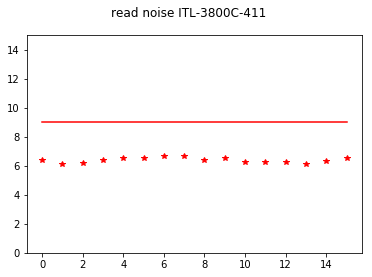

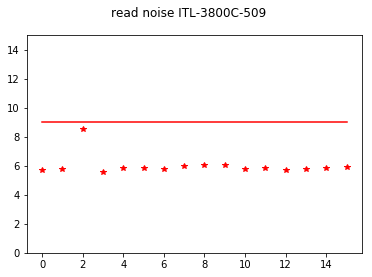

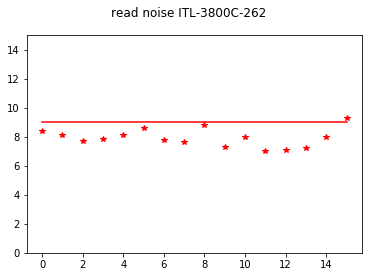

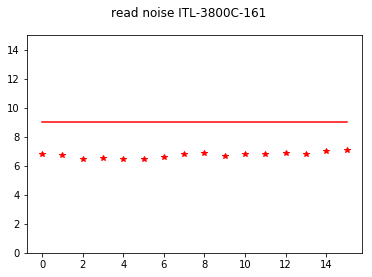

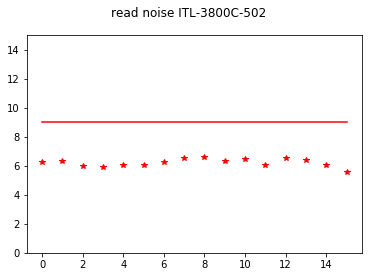

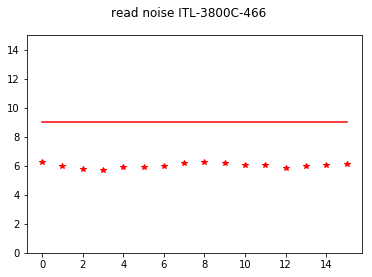

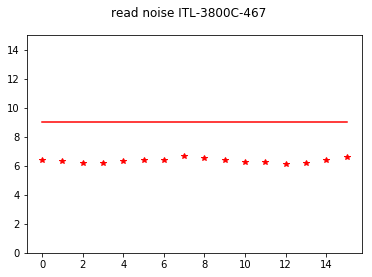

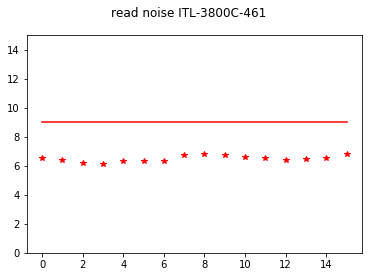

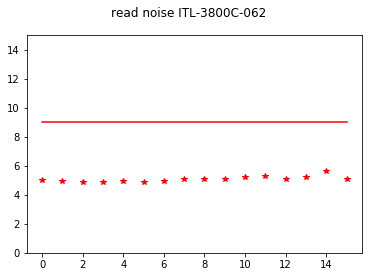

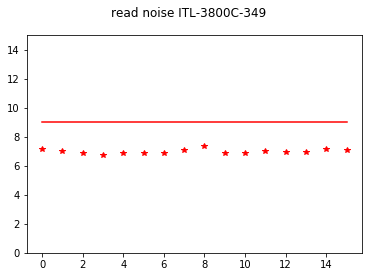

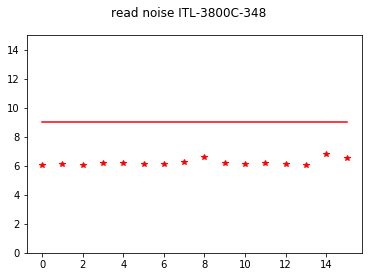

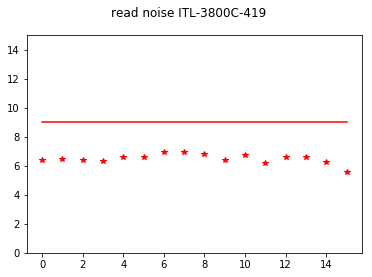

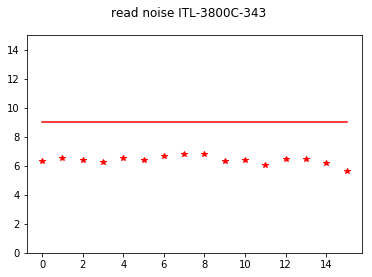

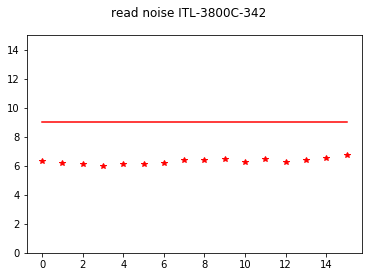

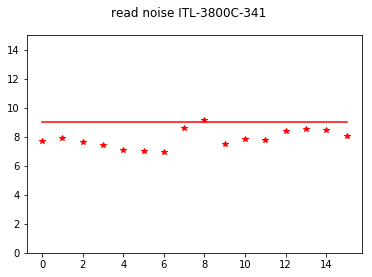

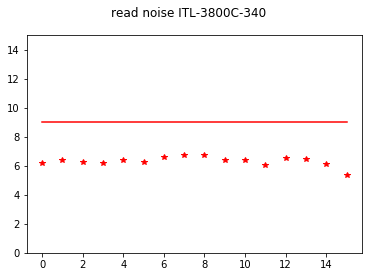

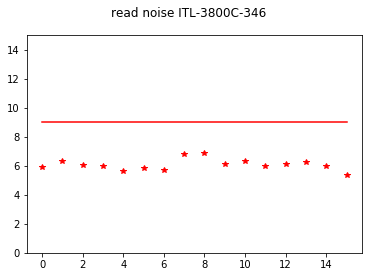

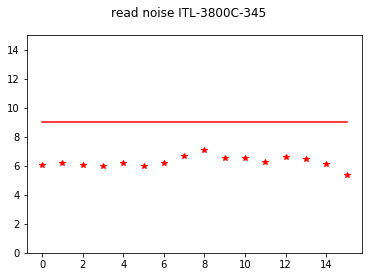

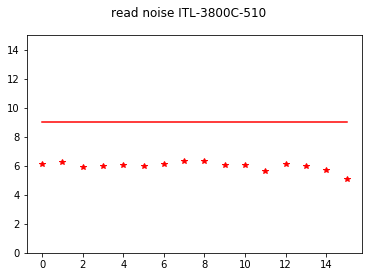

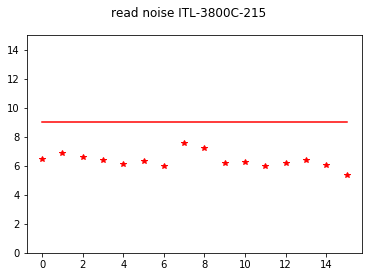

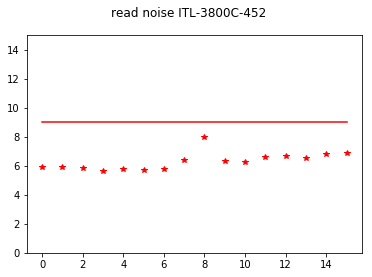

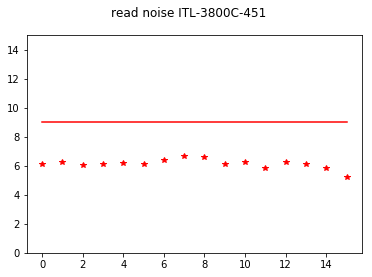

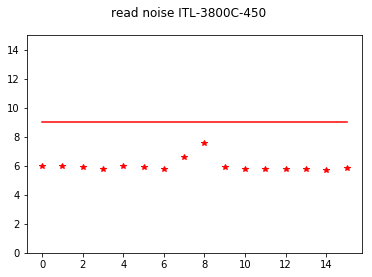

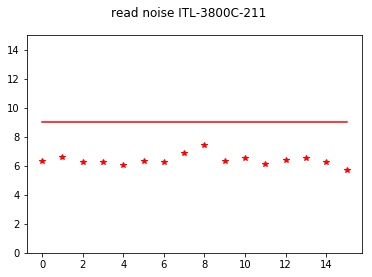

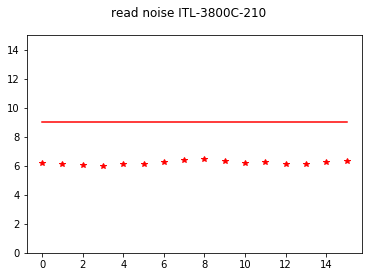

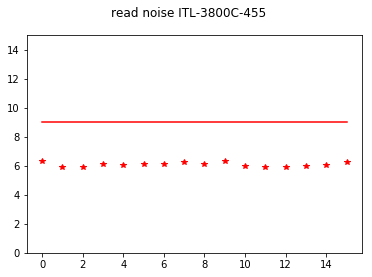

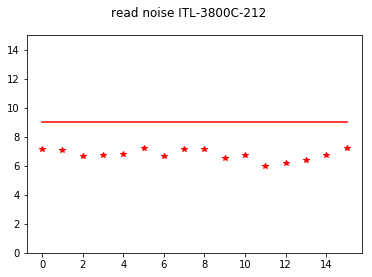

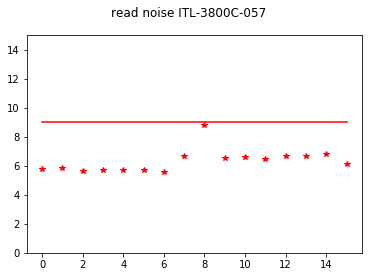

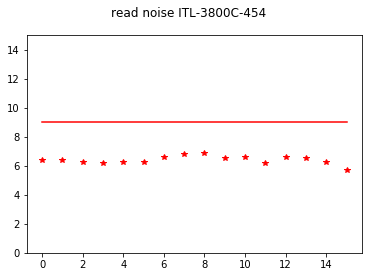

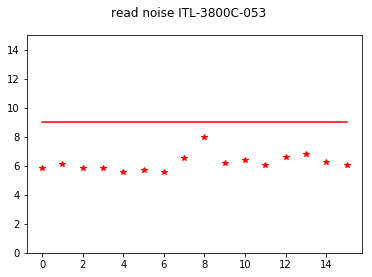

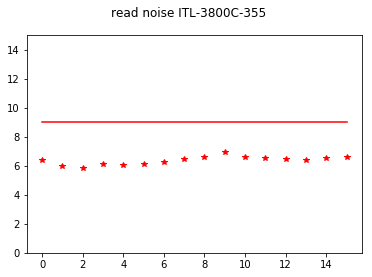

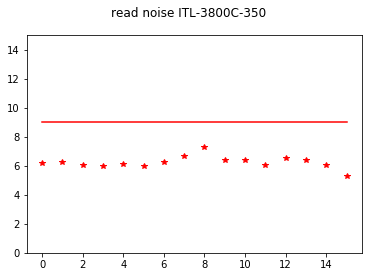

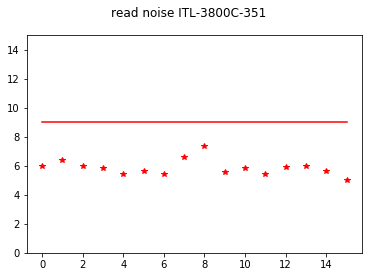

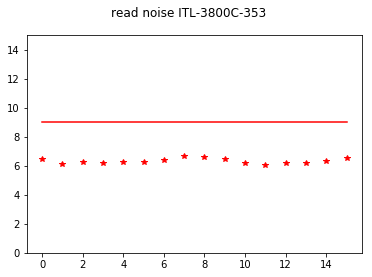

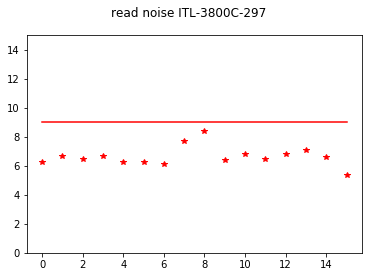

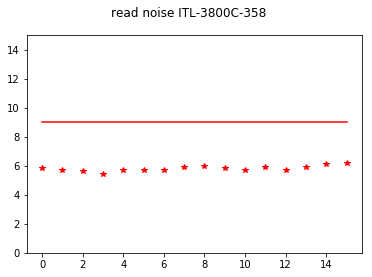

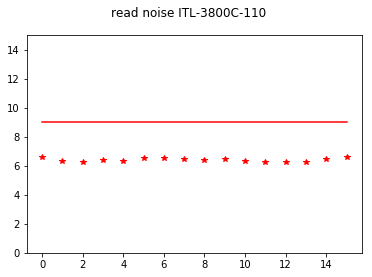

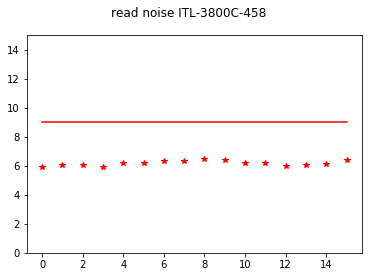

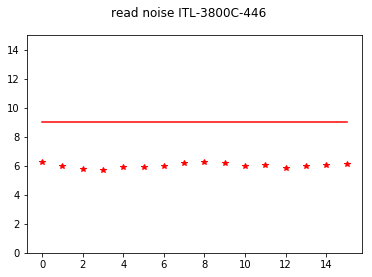

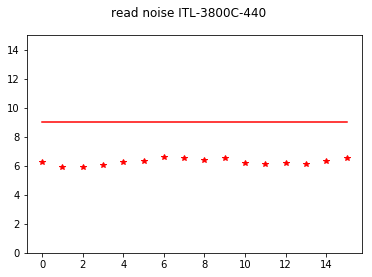

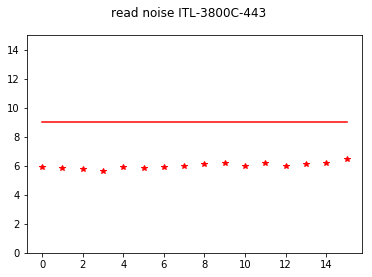

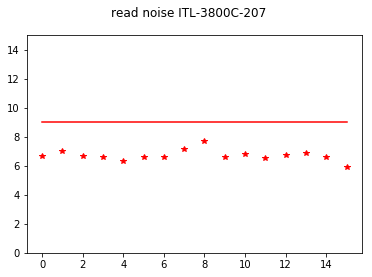

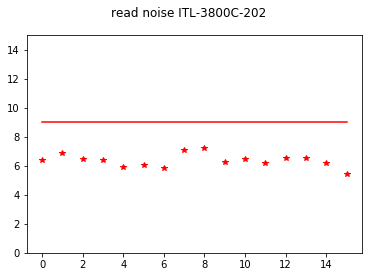

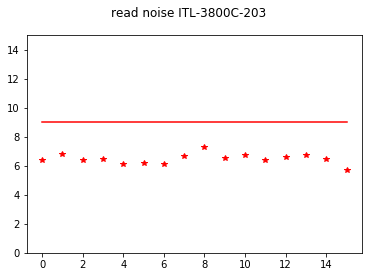

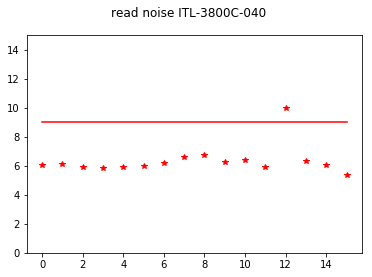

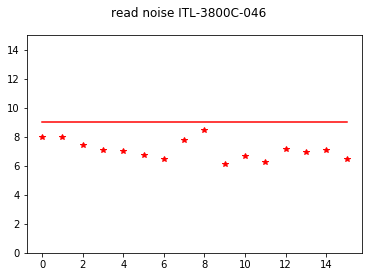

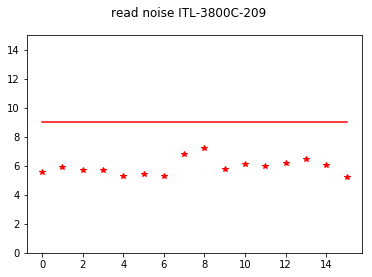

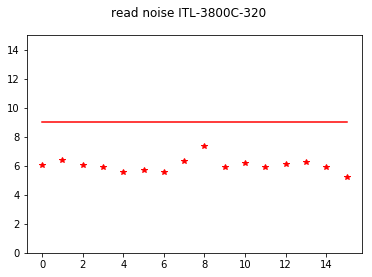

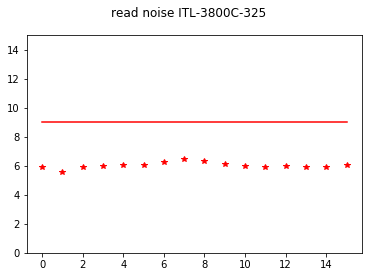

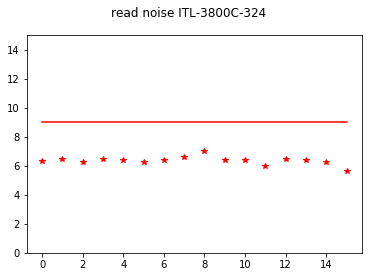

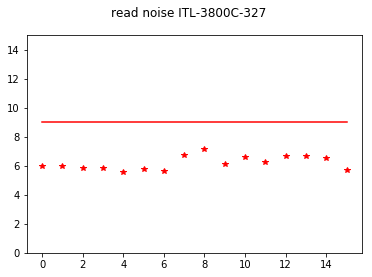

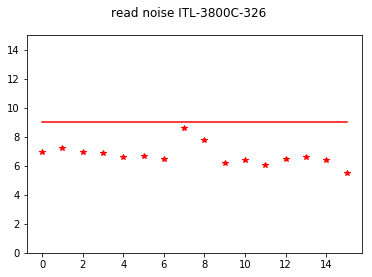

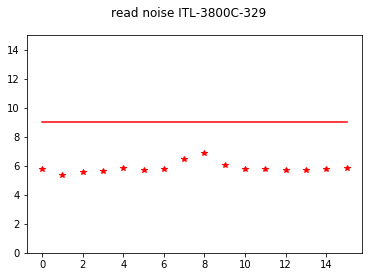

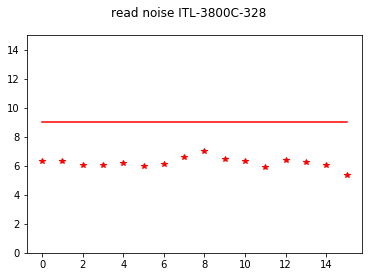

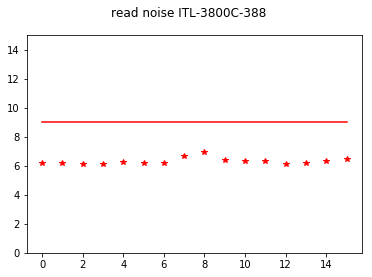

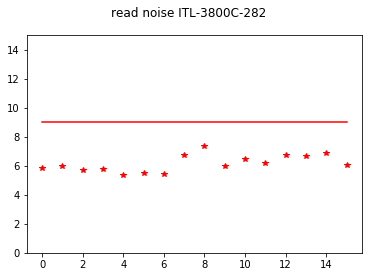

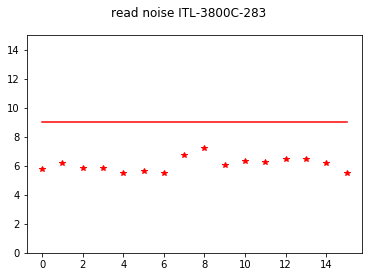

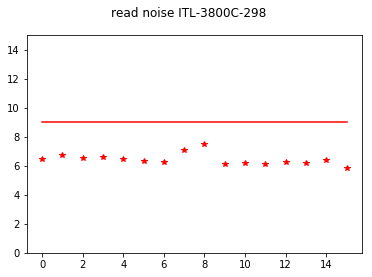

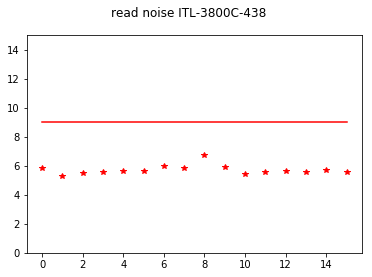

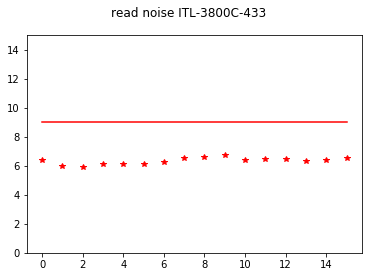

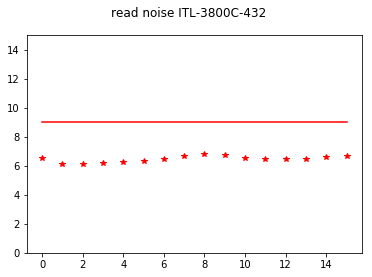

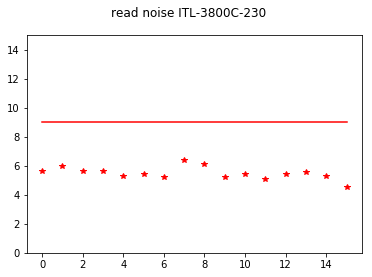

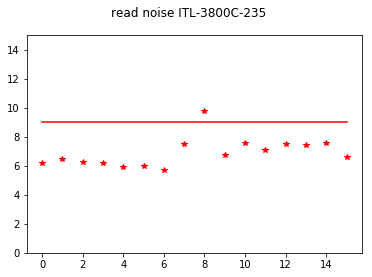

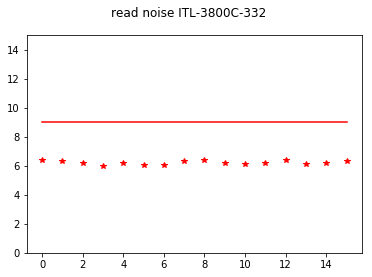

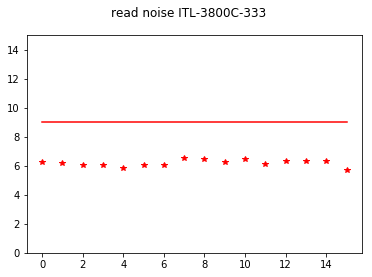

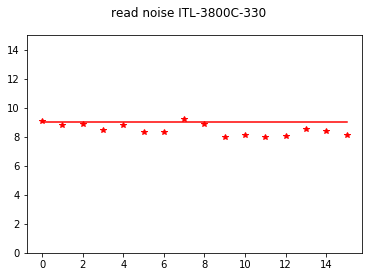

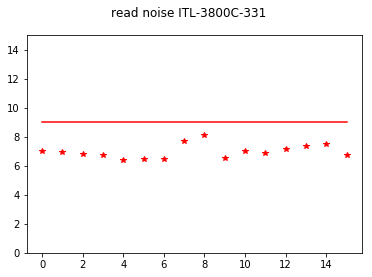

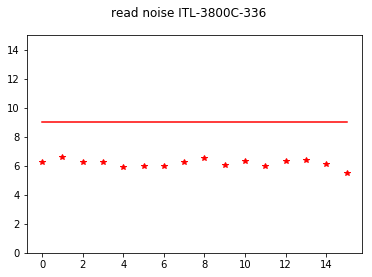

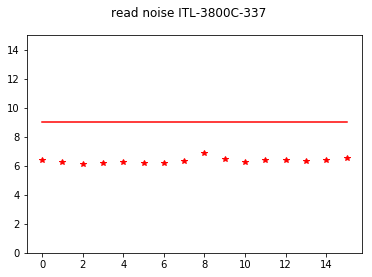

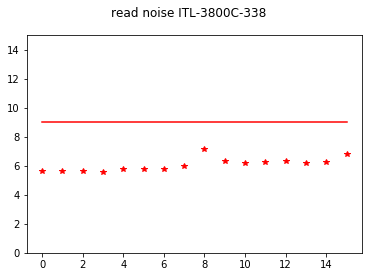

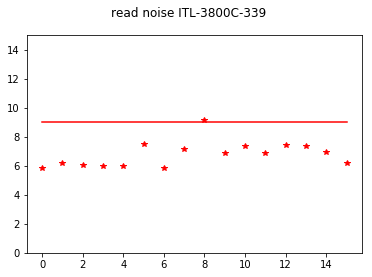

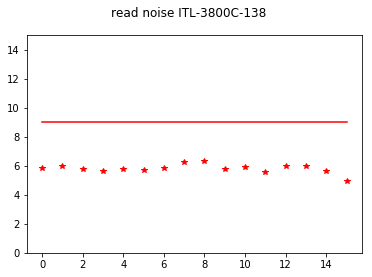

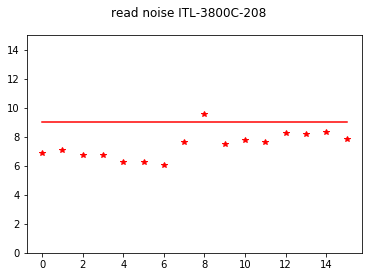

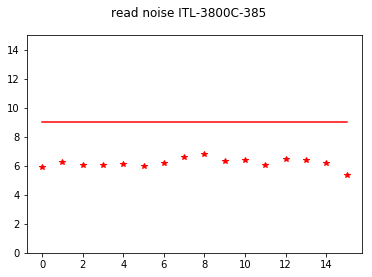

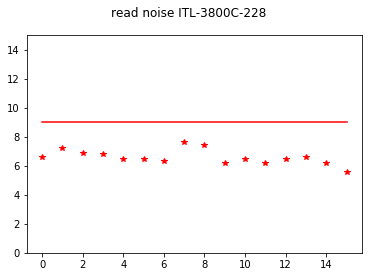

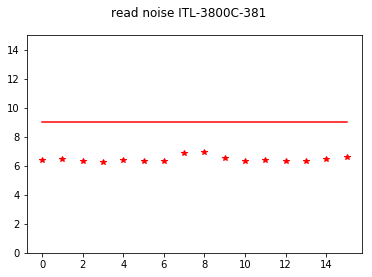

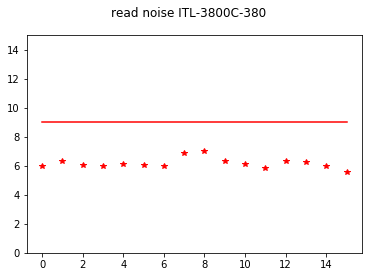

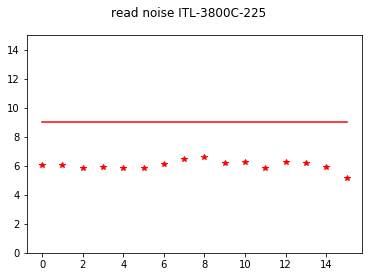

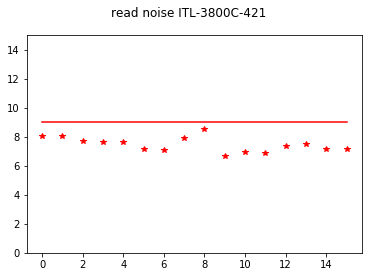

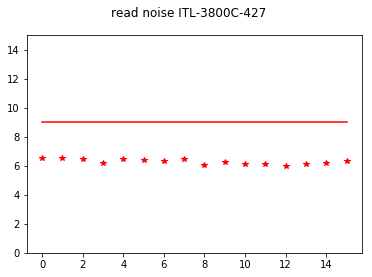

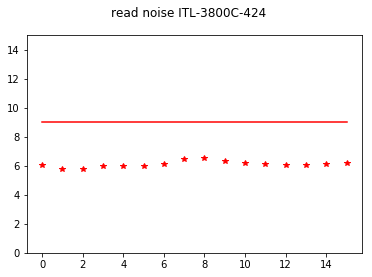

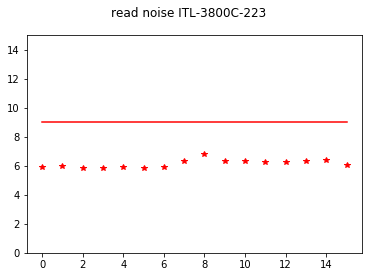

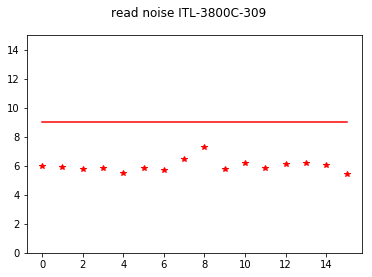

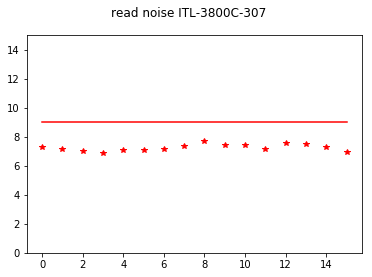

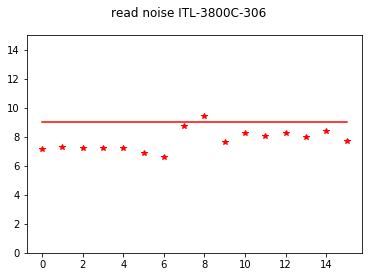

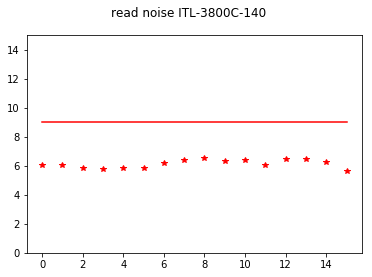

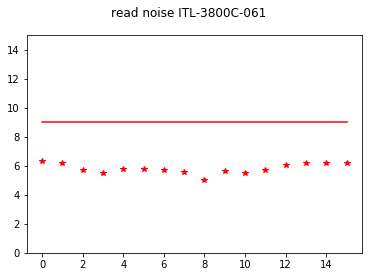

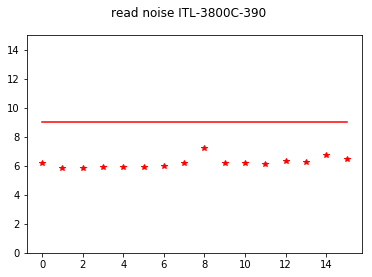

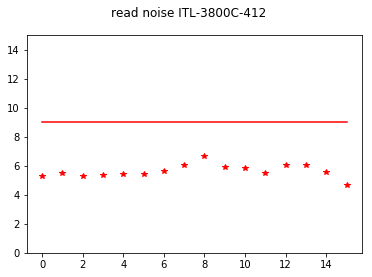

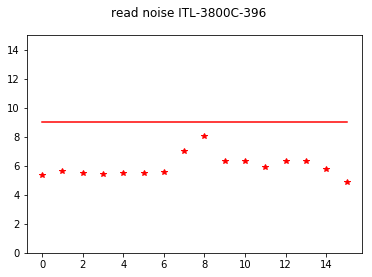

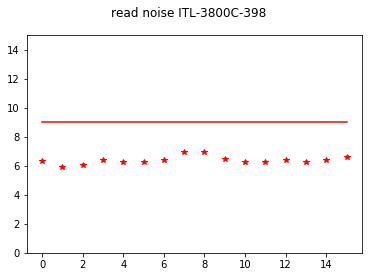

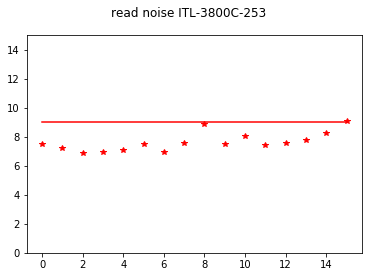

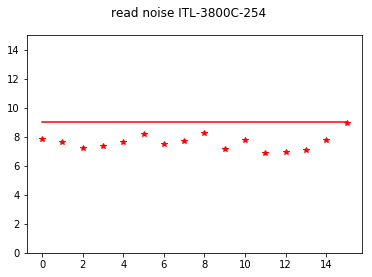

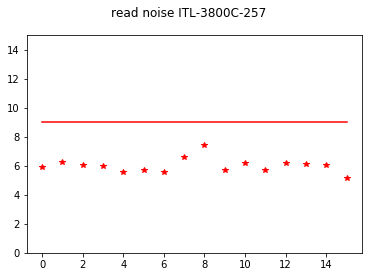

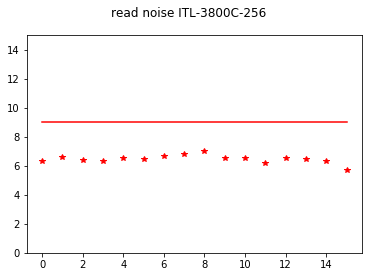

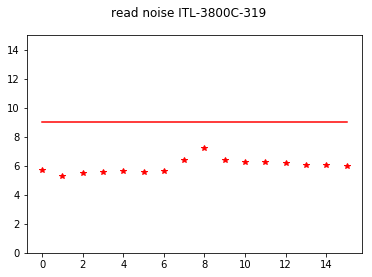

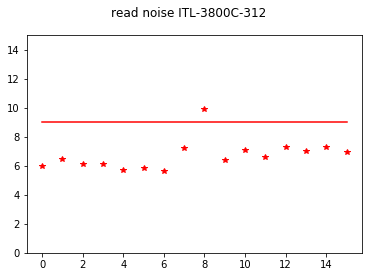

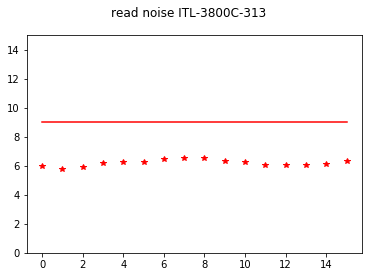

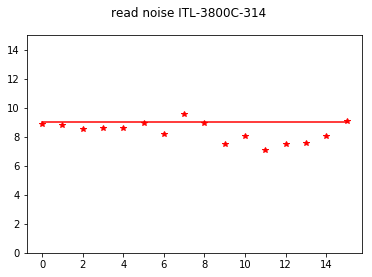

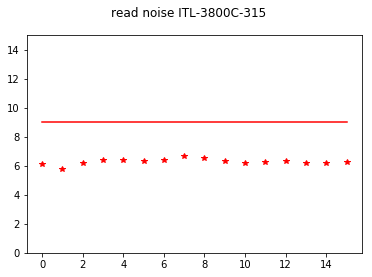

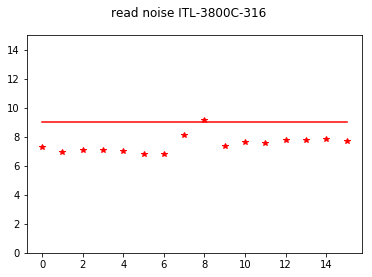

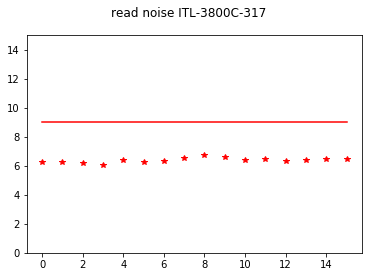

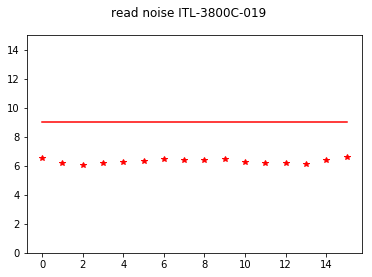

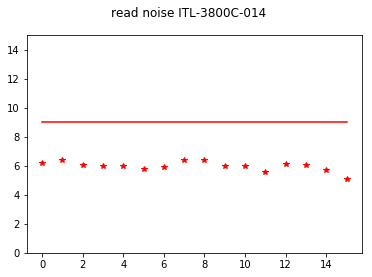

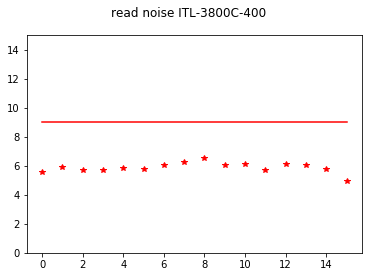

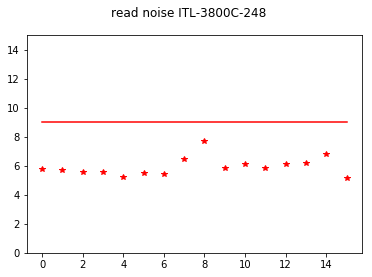

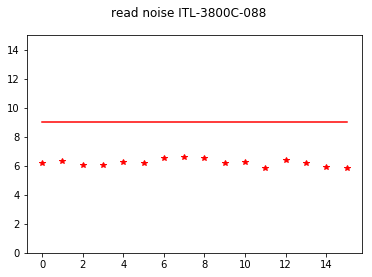

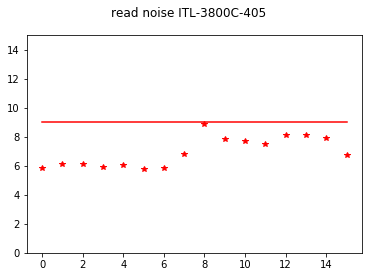

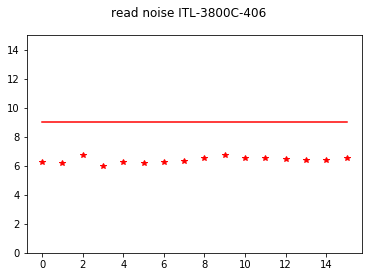

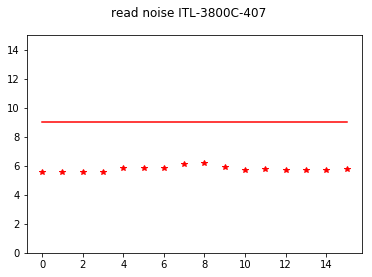

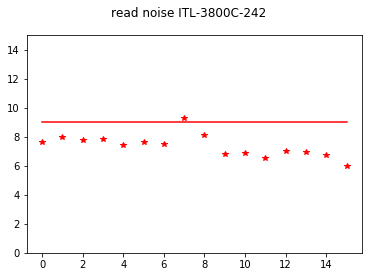

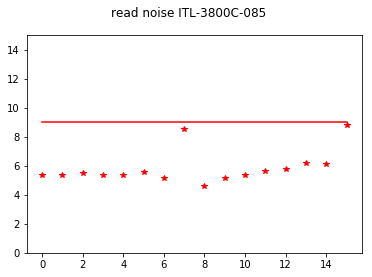

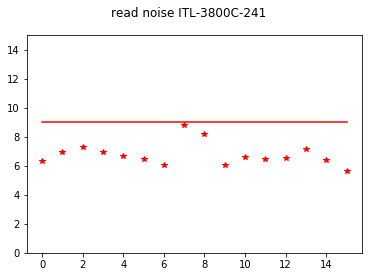

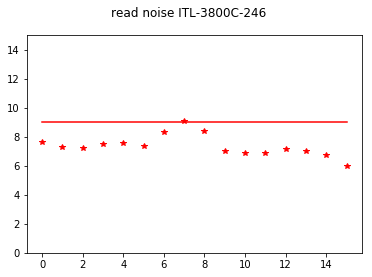

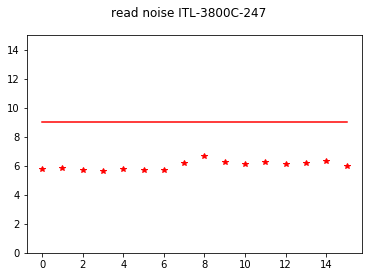

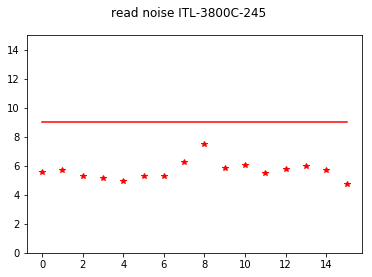

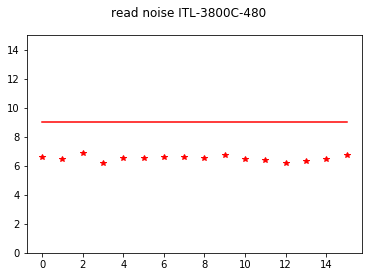

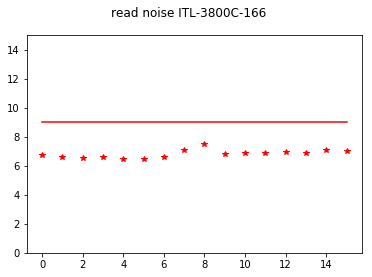

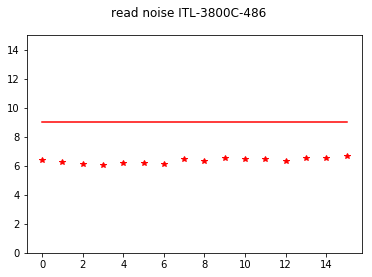

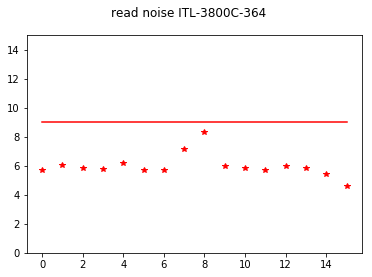

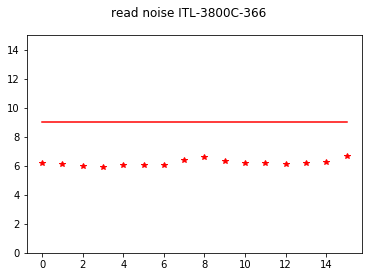

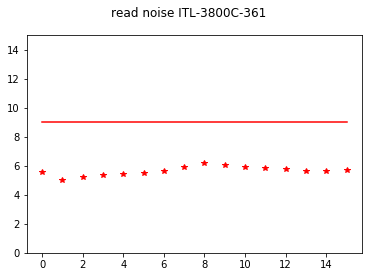

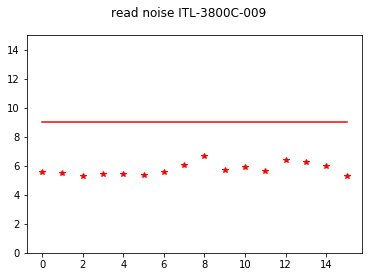

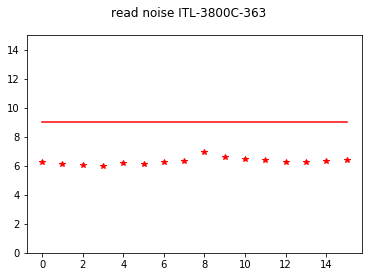

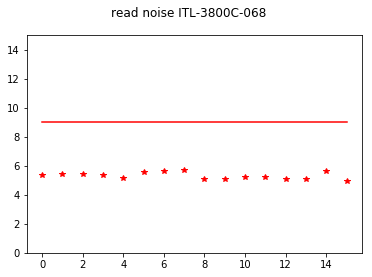

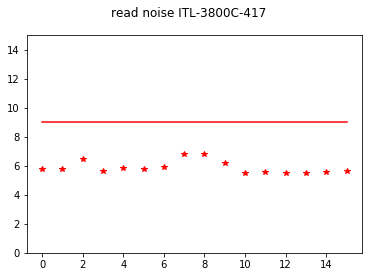

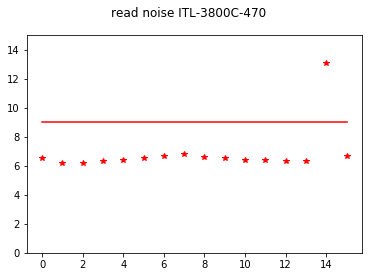

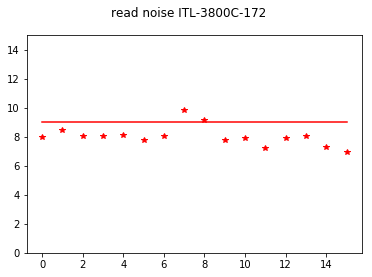

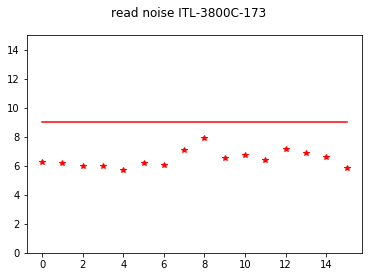

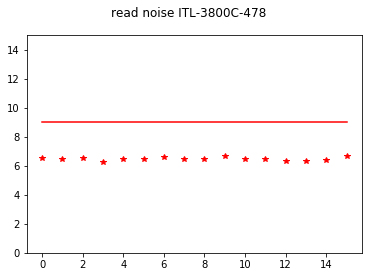

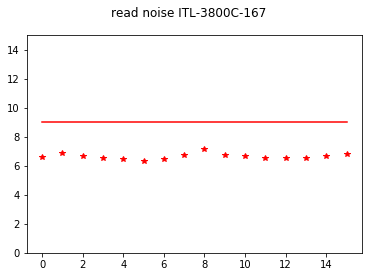

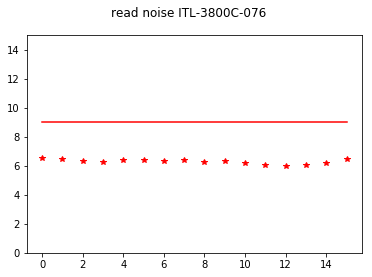

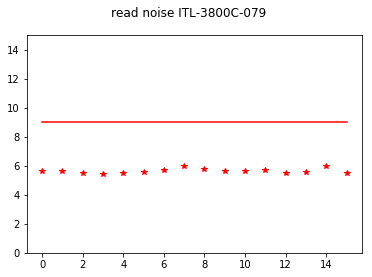

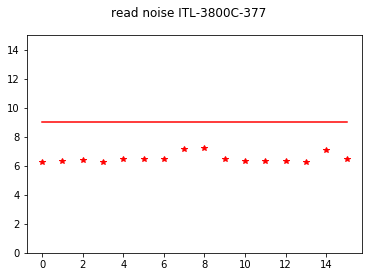

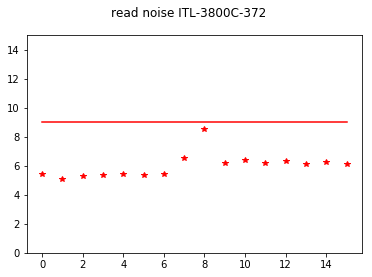

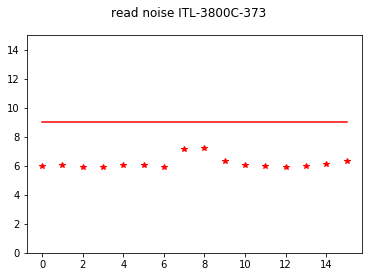

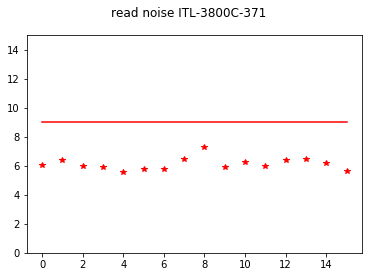

In [8]:
df =metric(ccd_list, expDict, bias_dic, RTM_dic)
df.RTM=df['RTM'].str[-3:]
df.RTM = pd.to_numeric(df.RTM)
#print (df['RTM'])
#print(df.sort_values(by='Score'))
#df.str.len(df['RTM'])
#x= df['RTM']
#print(x)
#len(x)


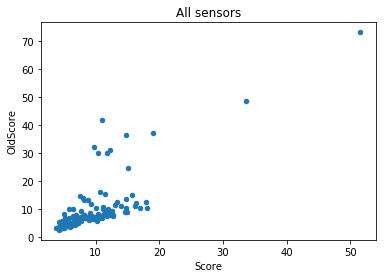

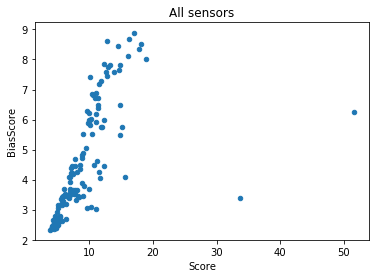

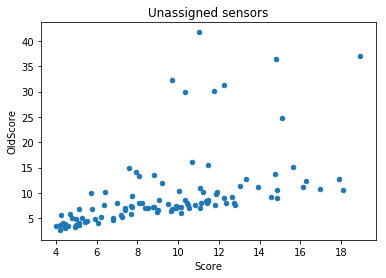

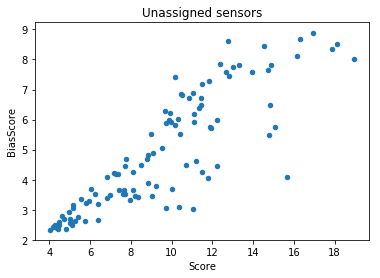

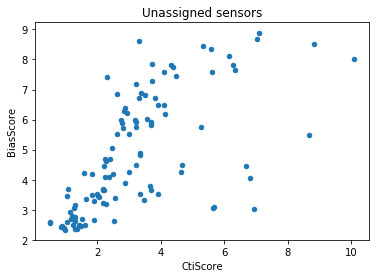

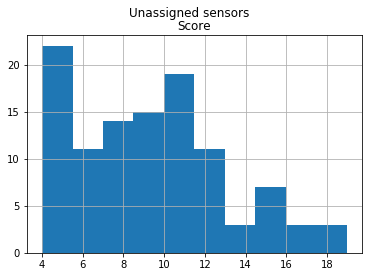

In [9]:
df.plot.scatter(x='Score',y='OldScore',title='All sensors')
df.plot.scatter(x='Score',y='BiasScore', title = 'All sensors')
z=df[(df.Score <= 20 ) & (np.isnan(df.RTM))] # select ones not shown to be on rafts in etraveler
#print (z['RTM'])
z.plot.scatter(x='Score',y='OldScore',title='Unassigned sensors')
z.plot.scatter(x='Score',y='BiasScore', title='Unassigned sensors')
z.plot.scatter(x='CtiScore',y='BiasScore', title='Unassigned sensors' )
z.hist(column='Score')
pl.suptitle("Unassigned sensors")
#plt.scatter(x, y, 80,'b','^',label='', alpha=0.65)
#print (z['Score'])
#print(z)

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
#print(z.sort_values(by='Score'))
z1=z[['Score','BiasScore','CtiScore', 'DefectScore', 'NonlinScore']]
pd.set_option('display.max_rows',200)
print ('number of sensors found in etraveler: ',len(df),'\n')
print ('\n number of unassigned sensors: ',len(z1),'\n')
round(z1.nsmallest(300,'Score'),2)

number of sensors found in etraveler:  137 


 number of unassigned sensors:  108 



,Score,BiasScore,CtiScore,DefectScore,NonlinScore
ITL-3800C-076,4.02,2.34,1.00,0.01,0.68
ITL-3800C-470,4.19,2.41,0.89,0.00,0.88
ITL-3800C-502,4.22,2.47,0.89,0.01,0.85
ITL-3800C-478,4.27,2.49,1.42,0.07,0.30
ITL-3800C-480,4.31,2.44,0.84,0.07,0.96
ITL-3800C-019,4.36,2.40,0.96,0.00,1.00
ITL-3800C-140,4.37,2.47,1.47,0.00,0.42
ITL-3800C-419,4.43,2.35,1.35,0.13,0.60
ITL-3800C-355,4.45,2.59,1.06,0.00,0.79
ITL-3800C-040,4.46,2.50,1.25,0.01,0.70


and we can easily export any of this to an excel file, if you want it.

In [12]:
df.describe()


,OldScore,Score,CtiScore,DefectScore,NonlinScore,BiasScore,RTM
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,27.000000
mean,9.485980,9.121168,3.357050,0.452369,0.813771,4.497978,11.666667
std,9.409135,5.540543,4.530513,1.081629,0.318038,1.876045,5.663649
min,2.681793,3.805679,0.511468,0.000946,0.143533,2.334891,4.000000
25%,5.020647,5.408856,1.516522,0.004639,0.688630,2.917639,4.000000
50%,7.093671,7.952868,2.410732,0.065460,0.754496,3.896273,14.000000
75%,9.842894,11.113187,3.677101,0.248810,0.882462,5.932042,17.000000
max,73.166070,51.598877,43.883984,8.722778,1.957874,8.896491,17.000000


In [13]:
z1.describe()

,Score,BiasScore,CtiScore,DefectScore,NonlinScore
count,108.000000,108.000000,108.000000,108.000000,108.000000
mean,9.333346,4.817103,3.162250,0.547882,0.806111
std,3.650580,1.944518,1.900860,1.200001,0.337978
min,4.021806,2.338765,0.511468,0.000946,0.143533
25%,6.190003,3.192613,1.833850,0.004684,0.660646
50%,9.141410,4.256657,2.812151,0.065521,0.752093
75%,11.479758,6.311186,3.836084,0.328171,0.886540
max,18.948533,8.896491,10.080841,8.722778,1.957874


In [14]:
# we see that some sensors may be missing from the etraveler search. 
# to help debug, here is the list of sensors found in etraveler, sorted by 
# sensor number:
#list(df.index)

As of 17 July, there are 18 sensors that are in principle available but that do not yet have stnadard bias measurements, plus some additional sensors already on rafts that do not have standard bias measurements recorded in eTraveler. Here are the sensor numbers:


034, RTM8

072, RTM8

083, RTM8

095, RTM8

136, RTM8

142, **available**

156, RTM10

157, RTM10

160, RTM10

164, RTM8

205, RTM10

206, ** available **

226, RTM8

227, RTM8

229, ** available **

244, RTM10

251, ** available **

261, RTM10

262, ** available **

269, RTM10

308, ** available **

318, RTM10

334, ** available **

415, ** available but some problems, sent back? **

508 ** available, new awaiting bias test **


080, ** available **

092,  considered “engineering, non-compliant, worth another look?

125,  considered “engineering, non-compliant, worth another look?

127, ** available **

220, ** available **

368, glow?

376, ** available **

423, ** available **

428, ** available **

430, ** available **

476, ** available **

479, ** available ** see notes on confluence page

506  ** available**

The ones on RTMs already we can let go for now, but the ones marked ** available ** should somehow be merged into the bigger group for ranking. 11 of these haven’t had bias measurements (according to HyeYun: 080, 127, 220, 376, 423, 428, 430, 476, 479, 506, 508)), so we cannot process them.

That leaves for now only 6 (142, 206, 229, 251, 308, 334) that don’t have eT bias values from the standard method plus one mystery device (262) that should be in eT but seems not to be — perhaps it was entered within the last couple of days?

Bottom line: I think we want to address the above 18 sensors relatively soon, but it should not hold up the assignment for the next RTM.